<a href="https://colab.research.google.com/github/tumanov-a/nlp_twitter/blob/main/preprocessing_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np # linear algebra
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import re
import os
import ktrain
import nltk

from ktrain import text
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

%matplotlib inline

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID';
os.environ['CUDA_VISIBLE_DEVICES']='0';
plt.style.use('ggplot')

In [6]:
df_train = pd.read_csv('/content/train.csv', index_col='id')
df_test = pd.read_csv('/content/test.csv', index_col='id')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [8]:
df_test.isnull().sum()

keyword       26
location    1105
text           0
dtype: int64

In [9]:
df_train.isnull().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
df_train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

Видно, что данный признак есть у обоих классов, поэтому признак не годится для использования:

In [ ]:
df_train.groupby(['keyword', 'target']).text.count().head(50)

keyword              target
ablaze               0         23
                     1         13
accident             0         11
                     1         24
aftershock           0         34
airplane%20accident  0          5
                     1         30
ambulance            0         18
                     1         20
annihilated          0         23
                     1         11
annihilation         0         19
                     1         10
apocalypse           0         23
                     1          9
armageddon           0         37
                     1          5
army                 0         29
                     1          5
arson                0         10
                     1         22
arsonist             0         26
                     1          8
attack               0         11
                     1         25
attacked             0         14
                     1         21
avalanche            0         26
                    

In [ ]:
df_train[df_train['target'] == 0][['keyword', 'text']].sample(20)

,keyword,text
id,,
9779,trapped,Hollywood Movie About Trapped Miners Released ...
6491,injuries,in fact if y'all could tag like small creeping...
7074,meltdown,A back to school commercial came on and my sis...
4385,earthquake,#Sismo M 1.3 - 1km NNE of The Geysers Californ...
6847,loud%20bang,ColnHarun: Breaking news! Unconfirmed! I just ...
4275,drowning,Louis in red jacket round 2 aka drowning in my...
412,apocalypse,Julie + R is the apocalypse version of Romeo +...
6687,landslide,So when you're caught in a landslide\nI'll be ...
1251,blood,another day another excellent @_dangerousbeans...


In [ ]:
df_train.groupby(['target', 'location'])['text'].count()

target  location
0       0           1458
        1           2884
1       0           1075
        1           2196
Name: text, dtype: int64

In [11]:
df_train.drop(columns=['keyword', 'location'], inplace=True)
df_test.drop(columns=['keyword', 'location'], inplace=True)

Видим, что присутсвуют ссылки, отмеченные пользователи и хештеги. 

In [12]:
df_train[df_train.target == 1].text.tolist()

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA 

In [ ]:
df_train[df_train.target == 0].text.tolist()

["What's up man?",
 'I love fruits',
 'Summer is lovely',
 'My car is so fast',
 'What a goooooooaaaaaal!!!!!!',
 'this is ridiculous....',
 'London is cool ;)',
 'Love skiing',
 'What a wonderful day!',
 'LOOOOOOL',
 "No way...I can't eat that shit",
 'Was in NYC last week!',
 'Love my girlfriend',
 'Cooool :)',
 'Do you like pasta?',
 'The end!',
 'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw',
 'Crying out for more! Set me ablaze',
 'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N',
 "@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.",
 'Ablaze for you Lord :D',
 'Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw',
 "on the outside you're ablaze and alive\nbut you're dead inside",
 'Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of 

Посчитаем количество хештегов, профилей, ссылок, длину текста:

In [13]:
df_train['count_hashtags'] = df_train['text'].apply(lambda x: len(re.findall(r'[#][A-z]+', x)))
df_train['count_profiles'] = df_train['text'].apply(lambda x: len(re.findall(r'[@][A-z]+', x)))
df_train['count_links'] = df_train['text'].apply(lambda x: len(re.findall(r't.co', x)))

df_test['count_hashtags'] = df_test['text'].apply(lambda x: len(re.findall(r'[#][A-z]+', x)))
df_test['count_profiles'] = df_test['text'].apply(lambda x: len(re.findall(r'[@][A-z]+', x)))
df_test['count_links'] = df_test['text'].apply(lambda x: len(re.findall(r't.co', x)))

In [14]:
df_train['len_text'] = df_train['text'].apply(lambda x: len(x))
df_test['len_text'] = df_test['text'].apply(lambda x: len(x))

Посмотрим, как зависят эти признаки от таргета:

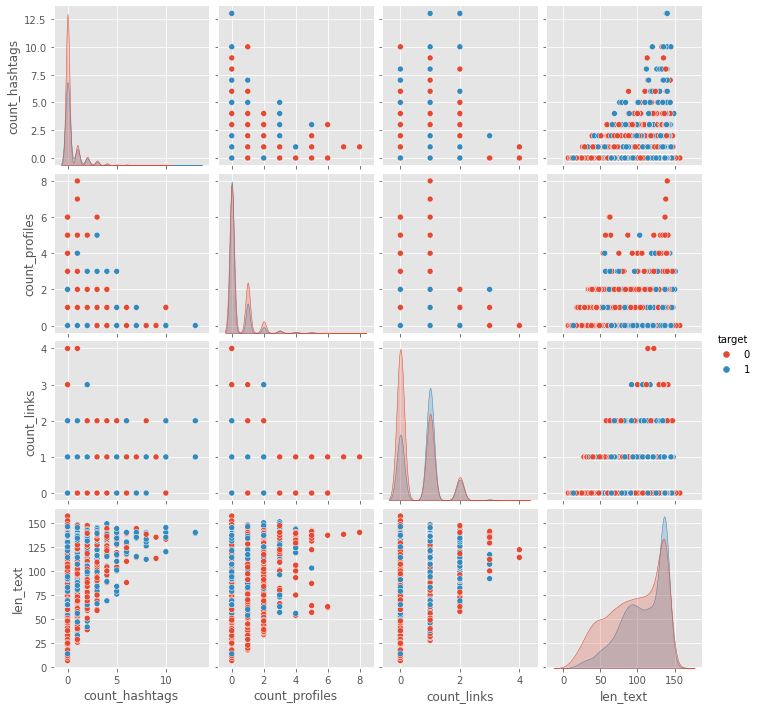

In [16]:
sns.pairplot(df_train[['count_hashtags', 'count_profiles', 'count_links', 'len_text', 'target']], hue='target')

Не думаю, что эти признаки будут чем-то полезны в модели, т.к. распределения практически не меняются в зависимости от таргета.

Уберем дубли из df_train:

In [18]:
df_train.shape

(7613, 6)

In [19]:
df_train.text.nunique()

7503

In [20]:
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([seq for seq in x.split('http') if 't.co' not in seq]))
df_train.text.nunique()

6829

In [21]:
df_train.drop_duplicates(['text'], inplace=True)

In [22]:
df_test['text'] = df_test['text'].apply(lambda x: ' '.join([seq for seq in x.split('http') if 't.co' not in seq]))

In [23]:
df_train.text.tolist()

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA 

Сделаем некоторые замены, которые в последствие помогут улучшить качество классификатора:

In [24]:
def replace(x):
  x = re.sub('\n', '', x)
  x = re.sub('([#@])', '', x)
  x = re.sub('åê', ' ', x)
  x = re.sub('åêåê', ' ', x)
  x = re.sub('ìâå', '', x)
  x = re.sub('ìñ', ' ', x)
  x = re.sub('aug06', 'aug 06', x)
  x = re.sub('awesomeeeeeeee', 'awesome', x)
  x = re.sub('awesomelove', 'awesome love', x)
  x = re.sub('awesomesauce', 'awesome sauce', x)
  x = re.sub('becuase', 'because', x)
  x = re.sub('beyoncì', 'beyonce', x)
  x = re.sub('bfore', 'before', x)
  x = re.sub('bioterrorismi', 'bioterrorism', x)
  x = re.sub('cafì', 'cafe', x)
  x = re.sub('carryi', 'carry', x)
  x = re.sub('cluei', 'clue', x)
  x = re.sub('courtof', 'court of', x)
  x = re.sub('daaamn', 'damn', x)
  x = re.sub('damnnnn', 'damn', x)
  x = re.sub('dìäjìû', '', x)
  x = re.sub('fcked', 'fucked', x)
  x = re.sub('fcking', 'fucking', x)
  x = re.sub('fckng', 'fucking', x)
  x = re.sub('firefighte', 'firefighter', x)
  x = re.sub('firefightr', 'firefighter', x)
  x = re.sub('firefightr', 'firefighter', x)
  x = re.sub('firefigthers', 'firefighters', x)
  x = re.sub('freakingg', 'freaking', x)
  x = re.sub('fuckkkkkk', 'fuck', x)
  x = re.sub('fucboi', 'fuckboy', x)
  x = re.sub('humanityi', 'humanity', x)
  x = re.sub('hunhry', 'hungry', x)
  x = re.sub('latinoand', 'latino and', x)
  x = re.sub('looooool', 'lol', x)
  x = re.sub('looooooooooool', 'lol', x)
  x = re.sub('lolol', 'lol', x)
  x = re.sub('meelllttting', 'melting', x)
  x = re.sub('memes', 'meme', x)
  x = re.sub('memez', 'meme', x)
  x = re.sub('nooo', 'no', x)
  x = re.sub('noooo', 'no', x)
  x = re.sub('nooooo', 'no', x)
  x = re.sub('noooooooo', 'no', x)
  x = re.sub('nooooooooo', 'no', x)
  x = re.sub('noooooooooooo', 'no', x)
  x = re.sub('ohh', 'oh', x)
  x = re.sub('ohhh', 'oh', x)
  x = re.sub('ohhhh', 'oh', x)
  x = re.sub('okayyyyyy', 'ok', x)
  x = re.sub('okay', 'ok', x)
  x = re.sub('ooohshit', 'oooh shit', x)
  x = re.sub('ooooohshit', 'oooooh shit', x)
  x = re.sub('okay', 'ok', x)
  x = re.sub('orphanage', 'orphan age', x)
  x = re.sub('p_eople', 'people', x)
  x = re.sub('ph0tos', 'photos', x)
  x = re.sub('pusssssssssy', 'pussy', x)
  x = re.sub('revel8ion', 'revelation', x)
  x = re.sub('snowstormi', 'snowstorm', x)
  x = re.sub('suddendly', 'suddenly', x)
  x = re.sub('365disasters', '365 disasters', x)
  x = re.sub('4fake', '4 fake', x)
  x = re.sub('4success', '4 success', x)
  x = re.sub('911bombing', '911 bombing', x)
  x = re.sub('911health', '911 health', x)
  x = re.sub('aboooooortiooooonnnnns', 'abortions', x)
  x = re.sub('\x89û_', '', x)
  x = re.sub('\x89ûª', '', x)
  x = re.sub('\x89û¼', '', x)
  x = re.sub('\x89åè', '', x)
  x = re.sub('\x89ûï', '', x)
  x = re.sub('\x89ûò', '', x)
  x = re.sub('\x89åê', '', x)
  x = re.sub('\x89ì¼', '', x)
  x = re.sub('\x89ûó', '', x)
  x = re.sub('\x89â', '', x)
  x = re.sub('\x89å', ' ', x)
  x = re.sub('\x89_', ' ', x)
  x = re.sub('\x89ã¢', '', x)
  x = re.sub('&gt;', '', x)
  x = re.sub('&amp;', '', x)
  x = re.sub('&lt;', '', x)
  x = re.sub('\x9d', '', x)
  x = re.sub('\x89Ê', '', x)
  x = re.sub('\x89ìü', '', x)
  x = re.sub('\x89ÛÏ', '', x)
  x = re.sub('\x89Û', '', x)
  x = re.sub('ª', '', x)
  x = re.sub('â', '', x)
  x = re.sub('ìñ', '', x)
  x = re.sub('ìü', '', x)
  x = re.sub('ï', '', x)
  x = re.sub('ò', '', x)
  x = re.sub('Ò', '', x)
  x = re.sub('ó', '', x)
  x = re.sub('ì¼', '', x)
  x = re.sub('\x89Û÷', '', x)
  x = re.sub('÷', '', x)

  return x.strip()

In [25]:
df_train['text'] = df_train['text'].apply(replace)
df_test['text'] = df_test['text'].apply(replace)

In [26]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 9.9MB/s 


Задача несколько отличается от анализа сентимента, но на всякий случай проанализируем твиты на предмет позитивных/негативных формулировок:

In [27]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment_analyzer(sentence):
  analyzer = SentimentIntensityAnalyzer()
  sentiment_scores = analyzer.polarity_scores(sentence)
  return sentiment_scores

In [28]:
df_train['sentinment_analys'] = df_train['text'].apply(sentiment_analyzer)
df_test['sentinment_analys'] = df_test['text'].apply(sentiment_analyzer)

In [31]:
df_train = pd.concat([df_train, df_train['sentinment_analys'].apply(pd.Series)], axis=1)
df_test = pd.concat([df_test, df_test['sentinment_analys'].apply(pd.Series)], axis=1)

df_train.drop(columns=['sentinment_analys'], inplace=True)
df_test.drop(columns=['sentinment_analys'], inplace=True)

In [32]:
df_train

,text,target,count_hashtags,count_profiles,count_links,len_text,neg,neu,pos,compound
id,,,,,,,,,,
1,Our Deeds are the Reason of this earthquake Ma...,1,1,0,0,69,0.000,0.851,0.149,0.2732
4,Forest fire near La Ronge Sask. Canada,1,0,0,0,38,0.286,0.714,0.000,-0.3400
5,All residents asked to 'shelter in place' are ...,1,0,0,0,133,0.095,0.905,0.000,-0.2960
6,"13,000 people receive wildfires evacuation ord...",1,1,0,0,65,0.000,1.000,0.000,0.0000
7,Just got sent this photo from Ruby Alaska as s...,1,2,0,0,88,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...
10860,a siren just went off and it wasn't the Forney...,1,0,0,0,65,0.187,0.813,0.000,-0.4137
10862,Officials say a quarantine is in place at an A...,1,0,0,1,136,0.000,1.000,0.000,0.0000
10863,WorldNews Fallen powerlines on G:link tram: UP...,1,1,0,1,136,0.260,0.740,0.000,-0.6841


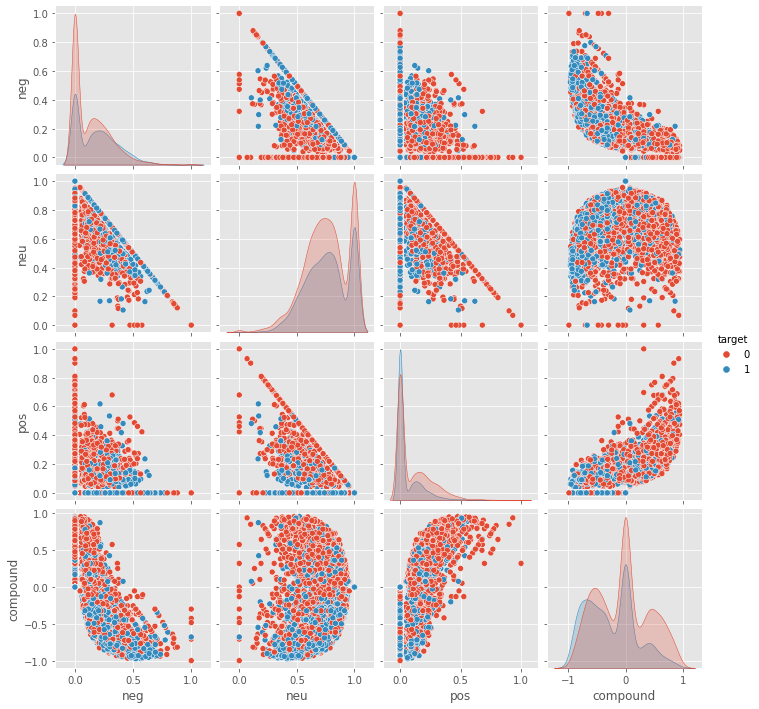

In [35]:
sns.pairplot(df_train[['neg', 'neu', 'pos', 'compound', 'target']], hue='target')

Распределения меняются у compound и частично у negative, возможно дадут модели улучшиться по качеству.

Проверим null-ы:

In [36]:
df_train.isnull().sum()

text              0
target            0
count_hashtags    0
count_profiles    0
count_links       0
len_text          0
neg               0
neu               0
pos               0
compound          0
dtype: int64

In [37]:
df_test.isnull().sum()

text              0
count_hashtags    0
count_profiles    0
count_links       0
len_text          0
neg               0
neu               0
pos               0
compound          0
dtype: int64

In [38]:
df_train

,text,target,count_hashtags,count_profiles,count_links,len_text,neg,neu,pos,compound
id,,,,,,,,,,
1,Our Deeds are the Reason of this earthquake Ma...,1,1,0,0,69,0.000,0.851,0.149,0.2732
4,Forest fire near La Ronge Sask. Canada,1,0,0,0,38,0.286,0.714,0.000,-0.3400
5,All residents asked to 'shelter in place' are ...,1,0,0,0,133,0.095,0.905,0.000,-0.2960
6,"13,000 people receive wildfires evacuation ord...",1,1,0,0,65,0.000,1.000,0.000,0.0000
7,Just got sent this photo from Ruby Alaska as s...,1,2,0,0,88,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...
10860,a siren just went off and it wasn't the Forney...,1,0,0,0,65,0.187,0.813,0.000,-0.4137
10862,Officials say a quarantine is in place at an A...,1,0,0,1,136,0.000,1.000,0.000,0.0000
10863,WorldNews Fallen powerlines on G:link tram: UP...,1,1,0,1,136,0.260,0.740,0.000,-0.6841


In [ ]:
y = np.array(df_train.pop('target'))

In [115]:
X = np.array(df_train[['text']])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Присутствует дисбаланс классов:

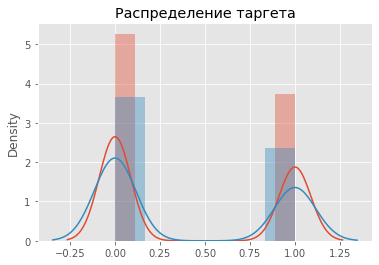

In [116]:
sns.distplot(y_train)
sns.distplot(y_val)
plt.title('Распределение таргета')
plt.show()

In [117]:
vect = CountVectorizer(ngram_range=(1,2))
scaler = StandardScaler()

X_train_text = vect.fit_transform(X_train[:, 0]).toarray()
X_val_text = vect.transform(X_val[:, 0]).toarray()

#X_train_counters = scaler.fit_transform(X_train[:, 1:])
#X_val_counters = scaler.transform(X_val[:, 1:])

#X_train = np.c_[X_train_counters, X_train_text]
#X_val = np.c_[X_val_counters, X_val_text]

In [118]:
vocab_size = len(vect.get_feature_names())

In [119]:
reg = [0.001, 0.01, 0.1, 1, 10, 100]
cross_val_scores = []

for val in reg:
  cvs = cross_val_score(LinearSVC(C=val, random_state=42), X_train_text, y_train, cv=3).mean()
  cross_val_scores.append(cvs)

best_reg = reg[np.array(cross_val_scores).argmax()]

linsvc = LinearSVC(C=best_reg, random_state=42)
linsvc.fit(X_train_text, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [120]:
linsvc.score(X_val_text, y_val)

0.8111273792093704

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val, lr.predict(X_val)))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='newton-cg')

lr.fit(X_train_text, y_train)

lr.score(X_val_text, y_val)

In [ ]:
feature_score = dict(np.c_[vect.get_feature_names(), linsvc.coef_[0][1:]])

In [ ]:
df_test['target'] = predictions

In [ ]:
df_test[['target']].to_csv('submission_after_del_leaks_emb.csv')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val, lr.predict(X_val)))

In [ ]:
scores = [0.78915, 0.79865, 0.79650, 0.79282, 0.78945, 0.79987, 0.78884, 0.78945, 0.81826]
ind = list(range(len(scores)))

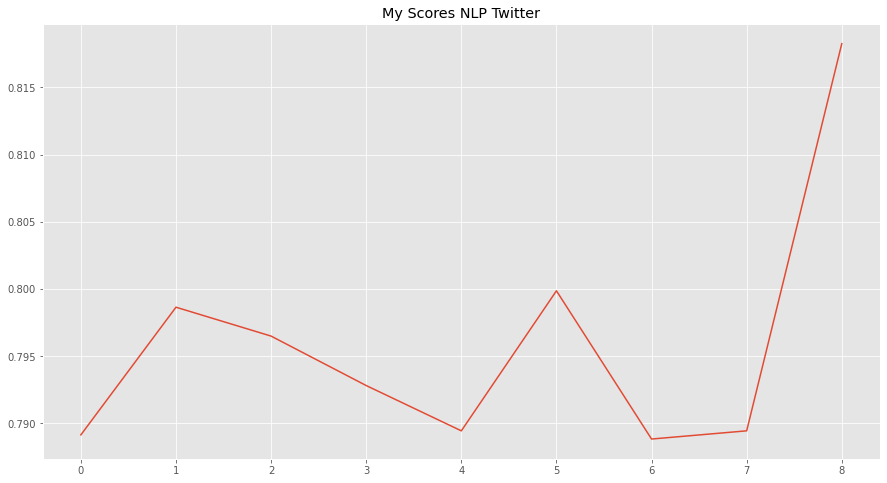

In [ ]:
plt.figure(figsize=[15,8])
sns.lineplot(ind, scores)
plt.title('My Scores NLP Twitter')
plt.show()

In [ ]:
(x_train, y_train), (x_val, y_val), preproc = text.texts_from_array(X_train, y_train, x_test=X_val, y_test=y_val, preprocess_mode='bert', random_state=42, class_names=['not disaster', 'disaster'])

In [ ]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_val, y_val), batch_size=12)
learner.lr_find(max_epochs=5)
learner.lr_plot()
learner.fit_onecycle(1e-5, 2)
predictor = ktrain.get_predictor(learner.model, preproc)
predicted_labels = predictor.predict(df_test.text.tolist())
df_test['target'] = predicted_labels
df_test['target'] = df_test['target'].map({'disaster': 1, 'not disaster': 0})
df_test[['target']].to_csv('submission_bert.csv')